In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
# import key libs
import os
import rasterio
import numpy as np
from tqdm import tqdm
from math import ceil
import multiprocessing as mp
import scipy as sp
from scipy.interpolate import interp1d

# import clustering related modules
# from cuml import UMAP
# from sknetwork.clustering import Louvain
import joblib
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split as TTS
from sklearn.preprocessing import minmax_scale, MinMaxScaler, StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score


# import plotting libs
import glasbey
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from src import *


In [3]:
# raw spectral data cube
hsi_fn = "/mnt/inputs/Peru_2023/Peru_D/Level_1/1.11_Datacubes/Peru_D_Refl_Crop.bil"

# set path to cluster fn
cluster_fn = ''

# set path to output directory on EFS
# out_dir = r'/home/azureuser/cloudfiles/code/Users/baichun.sun/studies/greenland/intermediate/disko_GM_clustering/'
out_dir = "/mnt/outputs/"  
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

In [ ]:
%%time
if os.path.exists(cluster_fn):
    # load the cluster map
    with rasterio.open(cluster_fn, 'r') as src:
        cluster_map = src.read(1)
    # create a boolean mask
    geo_map = np.invert(np.isin(cluster_map, [999, 6, 15, 5, 25, 26]))

    # plot for sanity check
    plt.imshow(geo_map)
    plt.show()
else:
    src = rasterio.open(hsi_fn, "r")
    print(src.shape)
    print(src.res)
    arr = src.read(30)
    src.close()
    geo_map = np.invert(np.isin(arr, [-99]))
    fig, ax=plt.subplots(1, 2)
    ax[0].imshow(geo_map)
    ax[1].imshow(arr)
    plt.show()

In [5]:
%%time
# use the geo map to sample the data cube
spc = 3.5 #m
samples = sample_parallel_Nth_pixel_with_map(hsi_fn, spacing=spc, label_map=geo_map)
samples.shape

Working on 12 processors...


100%|██████████| 6989/6989 [05:54<00:00, 19.72it/s]  


CPU times: user 31.8 s, sys: 28.1 s, total: 59.9 s
Wall time: 6min


(25160978, 125)

In [6]:
samples.shape

(25160978, 125)

In [7]:
# get wavelengths from cube
with rasterio.open(hsi_fn, 'r') as src:
    print(src.descriptions)
    wvl = np.array([float(x.split(' ')[-1].strip('()'))*1000 for x in src.descriptions])

# generate a rounded number in millions for the number of samples
N_samps = round(samples.shape[0] / 1000000, 2)

print(np.diff(wvl))
wvl.shape, N_samps

('Peru-D_Refl_001 (0.461600)', 'Peru-D_Refl_002 (0.476400)', 'Peru-D_Refl_003 (0.491100)', 'Peru-D_Refl_004 (0.505800)', 'Peru-D_Refl_005 (0.520500)', 'Peru-D_Refl_006 (0.535100)', 'Peru-D_Refl_007 (0.549800)', 'Peru-D_Refl_008 (0.564400)', 'Peru-D_Refl_009 (0.579100)', 'Peru-D_Refl_010 (0.593600)', 'Peru-D_Refl_011 (0.608200)', 'Peru-D_Refl_012 (0.622800)', 'Peru-D_Refl_013 (0.637300)', 'Peru-D_Refl_014 (0.651900)', 'Peru-D_Refl_015 (0.666400)', 'Peru-D_Refl_016 (0.680900)', 'Peru-D_Refl_017 (0.695400)', 'Peru-D_Refl_018 (0.709800)', 'Peru-D_Refl_019 (0.724300)', 'Peru-D_Refl_020 (0.738700)', 'Peru-D_Refl_021 (0.753100)', 'Peru-D_Refl_022 (0.767500)', 'Peru-D_Refl_023 (0.781800)', 'Peru-D_Refl_024 (0.796200)', 'Peru-D_Refl_025 (0.810500)', 'Peru-D_Refl_026 (0.824800)', 'Peru-D_Refl_027 (0.839100)', 'Peru-D_Refl_028 (0.853400)', 'Peru-D_Refl_029 (0.867700)', 'Peru-D_Refl_030 (0.881900)', 'Peru-D_Refl_031 (0.896200)', 'Peru-D_Refl_032 (0.900100)', 'Peru-D_Refl_033 (0.915700)', 'Peru-D_R

((125,), 25.16)

In [ ]:
# find 5 wavelengths either side of the atmospheric windows
w = np.ones(wvl.shape[0]).astype(bool)
for i in np.argwhere(np.diff(wvl) > 30).flatten():
    sp = 3 # 5
    for j in range(-sp, sp):
        w[i-j] = False

# discard 5 wavelenths at end & discard all wavelength < 750nm
w[:np.argmin(abs(wvl-750))] = False
w[-5:] = False

# visualise the spectral observation to keep and discard on random spectra
fig, axes = plt.subplots(3,2,figsize=(10, 10), constrained_layout=True)
fig.patch.set_alpha(0.0)
for i, ax in enumerate(axes.flatten()):
    idx = np.random.choice(np.arange(samples.shape[0]))
    ax.scatter(wvl[w], samples[idx,w], label='Keep')
    ax.scatter(wvl[~w], samples[idx,~w], label='Discard')
    ax.plot(wvl[w], samples[idx,w], c='k')
    ax.grid(linestyle='--')
    ax.set(title='Random Spectra', ylabel='Reflectance', xlabel='Wavelength (nm)', facecolor='#e6eaf6')
    ax.legend()
plt.show()

# CVX

In [9]:
%%time
# define a function that runs parallelised convex hull continuum removal
def convex_hull_cont_remove(X, wvl):
    N = mp.cpu_count()
    in_data = [(wvl, spec) for spec in X]
    # run parallised workflow
    with mp.Pool(processes=N) as p:
        results = p.map(calc_convex_hull, in_data) # per pixel upper monotone chain residual
    return np.stack(results)

# get convex hull continuum removed spectra
cvx_samples = convex_hull_cont_remove(samples[:,w], wvl[w])

CPU times: user 5min 15s, sys: 1min 47s, total: 7min 3s
Wall time: 14min 21s


In [10]:
cvx_samples.shape

(25160978, 88)

In [11]:
len(wvl[w])

88

# CWT

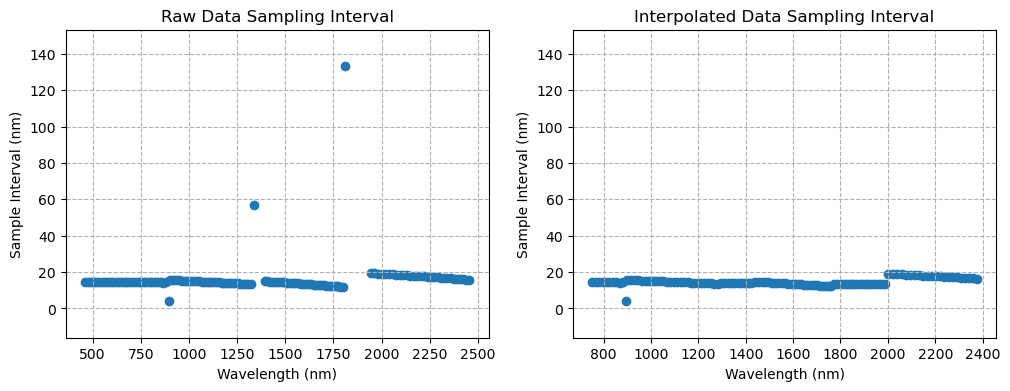

In [12]:
# create a set of new wavelengths to interpolate onto
new_wvl = []
clipped_wvl = wvl[w]
for i, a in enumerate(np.diff(clipped_wvl)):
    if a < 30:
        new_wvl.append(clipped_wvl[i])
    else:
        d = clipped_wvl[i+1] - clipped_wvl[i]
        nw = np.linspace(clipped_wvl[i], clipped_wvl[i+1], ceil(d/13))[:-1]
        for j in nw:
            new_wvl.append(j)
new_wvl.append(clipped_wvl[-1])
new_wvl = np.array(new_wvl)

# visualise this for sanity check
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(wvl[:-1], np.diff(wvl))
ax[1].scatter(new_wvl[:-1], np.diff(new_wvl))
[a.set(ylim=(np.diff(wvl).min()-20, np.diff(wvl).max()+20), ylabel='Sample Interval (nm)', xlabel='Wavelength (nm)') for a in ax]
[a.grid(linestyle='--') for a in ax]
ax[0].set(title='Raw Data Sampling Interval')
ax[1].set(title='Interpolated Data Sampling Interval')
plt.show()

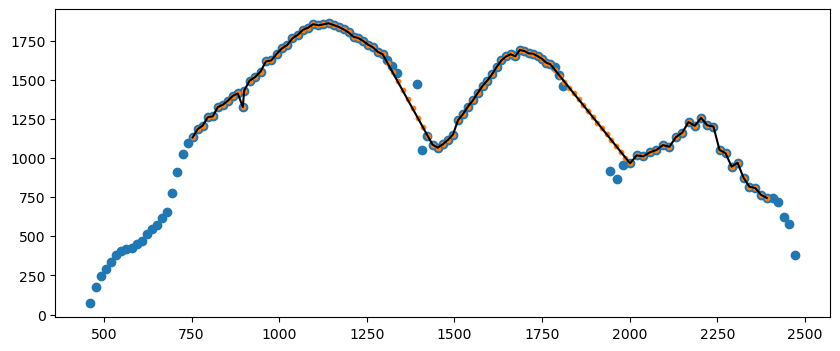

In [13]:
# run spectral resampling on the sample spectra
f = interp1d(clipped_wvl, samples[:,w].T, axis=0, kind='linear')
spectra_r = f(new_wvl).T

# plot some spectra
fig, ax = plt.subplots(figsize=(10,4))
idx = np.random.choice(np.arange(samples.shape[0]))
ax.scatter(wvl, samples[idx])
ax.plot(new_wvl, spectra_r[idx], c='k')
ax.scatter(new_wvl, spectra_r[idx], s=10,)
plt.show()

In [14]:
spectra_r.shape

(25160978, 113)

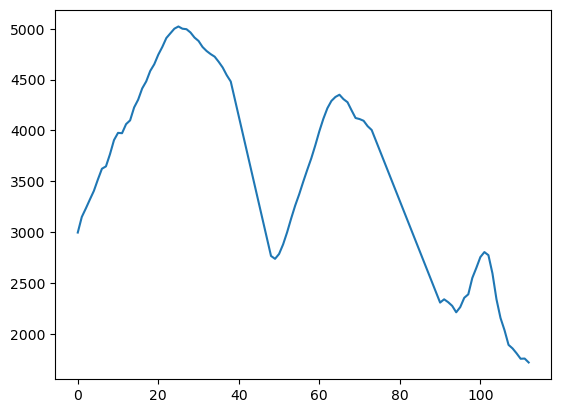

In [15]:
plt.plot(spectra_r[3])

In [16]:
samples.shape

(25160978, 125)

In [17]:
%%time
# write a function to generate continuous wavelet continuum removed spectra
def cwt_process(X, w):
    dj = 0.4
    dt = w[1] - w[0]
    wa = WaveletTransformTorch(dt, dj, DOG(m=2), unbias=False, cuda=True)
    pad_w = np.pad(w, (20), "symmetric", reflect_type="odd")
    result = []
    for i in tqdm(range(0, X.shape[0], 20000)):
        x_chunk = np.pad(X[i:i+20000], ((0, 0), (20, 20)), "symmetric", reflect_type="odd")
        if x_chunk.shape[0] == 1:
            coefs = np.array([wa.cwt(x_chunk)])
        else:
            coefs = wa.cwt(x_chunk)
        result.append(coefs[:, 1:9, 20:-20].sum(axis=1))
    return np.vstack(result)

# generate a CWT sample
cwt_sample = cwt_process(spectra_r, new_wvl)

100%|██████████| 1259/1259 [08:26<00:00,  2.48it/s]


CPU times: user 42min 8s, sys: 7min 15s, total: 49min 23s
Wall time: 8min 36s


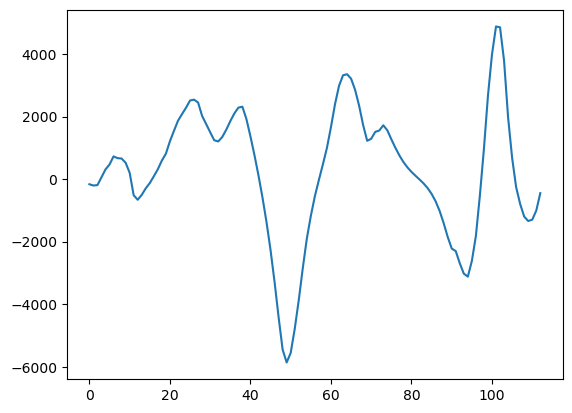

In [18]:

plt.plot(cwt_sample[1])

In [ ]:
# h = np.random.choice(np.arange(samples.shape[1]))
h = np.random.choice(np.arange(88))
print(h)
fig, ax=plt.subplots(1, 3, figsize=(16, 6))
sns.histplot(x=samples[:, h], kde=True, color='gray', stat='density', ax=ax[0])
sns.histplot(x=cvx_samples[:, h], kde=True, color='gray', stat='density', ax=ax[1])
sns.histplot(x=cwt_sample[:, h], kde=True, color='gray', stat='density', ax=ax[2])

## NDVI map

In [ ]:
out_fn = "*.tif"
calc_NDVI_map(hsi_fn, out_fn, wvl, -99)

In [20]:
cvx_samples.shape

(25160978, 88)

## Modelling

In [23]:
w

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False, False])

In [22]:
samples[:, w].shape

(25160978, 88)

In [ ]:
%%time
in_type = 'raw'
if in_type == 'raw':
    print(in_type)
    scaler = StandardScaler().fit(samples[:, w])
    X = scaler.transform(samples[:, w])
elif in_type=='cvx':
    print(in_type)
    scaler = StandardScaler().fit(cvx_samples)
    X = scaler.transform(cvx_samples)
elif in_type=='cwt':
    print(in_type)
    scaler = StandardScaler().fit(cwt_sample)
    X = scaler.transform(cwt_sample)
else: error('wrong in_type')

# Specify the number of clusters you want to identify
n_clusters = 27
# Create the GMM model
gmm = GaussianMixture(n_components=n_clusters)
# Fit the model to the data
gmm.fit(X)

In [19]:
if False:
    file_path = "*.pkl"
    # Save the GMM model using joblib
    joblib.dump(gmm, file_path)

In [20]:
gmm.means_

array([[ 0.        ,  0.42485537,  0.31289231, ...,  0.77510003,
         0.87249342,  0.        ],
       [ 0.        , -1.47225792, -1.74834111, ..., -1.28380723,
        -0.73824585,  0.        ],
       [ 0.        ,  0.44641574,  0.54108811, ...,  0.05084705,
        -0.23161544,  0.        ],
       ...,
       [ 0.        , -1.97417135, -2.32846647, ..., -1.8960447 ,
        -1.14700554,  0.        ],
       [ 0.        ,  0.48514903,  0.52312528, ...,  0.70436234,
         0.38340252,  0.        ],
       [ 0.        ,  0.41606459,  0.42640824, ...,  0.3419681 ,
         0.11764267,  0.        ]])

In [ ]:
%%time
# set output file name
out_fn = os.path.join(out_dir, 'clusters_gmm_cvx.tif')

# make a custom inference loop to write the class label, not probability
with rasterio.open(hsi_fn, 'r') as src:
    meta = src.meta.copy()
    meta.update({'count':1, 'driver':'GTIFF', 'BIGTIFF':'YES', 'nodata':999, 'dtype':'int16'})
    nodata_mask = src.read(1) == src.nodata
    with rasterio.open(out_fn, 'w', **meta) as dst:
        for ji, block in tqdm([x for x in src.block_windows()]):
            hsi_window = src.read(window=block)[:, 0, :].T
            nodata_window = nodata_mask[ji[0], :]
            if in_type=='cvx':
                hsi_window = scaler.transform(convex_hull_cont_remove(hsi_window[:, w], wvl[w]))
            elif in_type == 'raw':
                hsi_window = scaler.transform(hsi_window)
            
            pred_labels = gmm.predict(hsi_window)
            pred_labels[nodata_window] = 999
            dst.write(np.array([pred_labels]), 1, window=block) 

# edit nodata values  using the sampling map to mask out of bounds predictions
with rasterio.open(out_fn, 'r') as src:
    meta = src.meta.copy()
    with rasterio.open(out_fn.replace('.tif','_tmp.tif'), 'w', **meta) as dst:
        a = src.read(1)
        a[np.invert(geo_map)] = src.nodata
        dst.write(a, 1)

# remove original, rename masked file and convert to cloud optimised geotiff
os.remove(out_fn)
os.rename(out_fn.replace('.tif','_tmp.tif'), out_fn)
convert_to_cog(out_fn)